In [7]:
import os
import math  
import pickle
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from pathlib import Path
import sys
from sklearn.metrics import roc_curve, auc
import re

sys.path.append('/home/scarlett/github/ipython_notebook')
from Python.quickBeast import predict_BEASTIE_GAM_lambda, get_ROC_tsv,calculate_AUC_qb,get_NS_p_values,get_filename
from Python.ROC_common import Make_judgement
from Python.ROC_noLAMBDA import Prepare_data_fix, get_ROC_AUC


%matplotlib inline

In [23]:
def Make_judgement(Num_para,theta_pos=None,theta_neg=None,gene=None,hets=None,depth=None,sigma=0.5):
    thetas=[theta_pos,theta_neg]
    if thetas.count(None) >0:
        raise Exception('Both thetas could not be None. The number of None from input was {}'.format(thetas.count(None)))
    var=[gene,hets,depth,sigma]

    N = 4-Num_para
    if Num_para == 4:
        if var.count(None) > N:
            raise Exception('None of the variables could be set to None. The number of None from input was {}'.format(var.count(None)))
    elif Num_para == 3:
        if var.count(None) > N:
            raise Exception('One of the variables have to be set to None. The number of None from input was {}'.format(var.count(None)))
    elif Num_para == 2:
        if var.count(None) > N:
            raise Exception('Two variables have to be set to None. The number of None from input was {}'.format(var.count(None)))


def Prepare_data_fix_semi(gene, hets, depth, source, workdir, theta_pos, theta_neg, Num_para):
    var = [gene, hets, depth]
    var_map_np = np.array(['g', 'h', 'd'])  # Removed 'sigma'
    var_fullname_map_np = np.array(['gene', 'hets', 'depth'])
    full_var_map_np = np.array([gene, hets, depth])
    valid_var_np = var_map_np[np.array(var) != None]
    variable_var_np = var_fullname_map_np[np.array(var) == None]
    fixed_var_np = var_fullname_map_np[np.array(var) != None]
    valid_full_var_np = full_var_map_np[np.array(var) != None]

    # Assigning the fixed variables
    if hets is not None:
        h = hets
    if gene is not None:
        g = gene
    if depth is not None:
        d = depth

    # Update file path generation
    path_qb, _ = Generate_path_qb_MaxSite(source, workdir, calculation="pval")

    all_file = sorted(os.listdir(path_qb))

    file_dict = {}
    for file in all_file:
        # Skip files that contain unwanted substrings
        if ("tpi" not in file) and ("default" not in file) and ("log" not in file) and ("noerror" not in file):
            # Handle different postfixes
            if "CEU_enrichedEr" in workdir:
                postfix = "_CEU_enrichedEr"
            elif "CEU_rare" in workdir:
                postfix = "_CEU_rare"
            elif "CEU" in workdir:
                postfix = "_CEU"

            # Remove the postfix from the filename
            txt_file = file.replace(postfix, "")
            # Extract the core part of the filename (before .txt)
            name = txt_file.rsplit(".txt")[0].rsplit("_")
            # Initialize the dictionary for the current file
            file_dict[txt_file] = {}
            
            # Loop through the elements and extract key-value pairs
            for each_value in name:
                key, value = each_value.split("-")
                file_dict[txt_file][key] = float(value)
        else:
            continue

    # Convert file_dict to pandas DataFrame
    file_dict_pd = pd.DataFrame(file_dict).transpose()
    file_dict_pd['file'] = file_dict_pd.index

    # Handle different numbers of parameters
    if Num_para == 3:
        # Ensure there are at least 3 valid variables before filtering
        if len(valid_var_np) >= 3:
            pos_pd = file_dict_pd[
                (file_dict_pd[valid_var_np[0]] == valid_full_var_np[0]) &
                (file_dict_pd[valid_var_np[1]] == valid_full_var_np[1]) &
                (file_dict_pd[valid_var_np[2]] == valid_full_var_np[2]) &
                (file_dict_pd['t'] == theta_pos)
            ].sort_values(['d', 'h', 'g'])
            
            neg_pd = file_dict_pd[
                (file_dict_pd[valid_var_np[0]] == valid_full_var_np[0]) &
                (file_dict_pd[valid_var_np[1]] == valid_full_var_np[1]) &
                (file_dict_pd[valid_var_np[2]] == valid_full_var_np[2]) &
                (file_dict_pd['t'] == theta_neg)
            ].sort_values(['d', 'h', 'g'])
        else:
            raise IndexError("Insufficient variables for Num_para=3. Check input variables.")

    elif Num_para == 2:
        # Ensure there are at least 2 valid variables before filtering
        if len(valid_var_np) >= 2:
            pos_pd = file_dict_pd[
                (file_dict_pd[valid_var_np[0]] == valid_full_var_np[0]) &
                (file_dict_pd[valid_var_np[1]] == valid_full_var_np[1]) &
                (file_dict_pd['t'] == theta_pos)
            ].sort_values(['d', 'h', 'g'])
            
            neg_pd = file_dict_pd[
                (file_dict_pd[valid_var_np[0]] == valid_full_var_np[0]) &
                (file_dict_pd[valid_var_np[1]] == valid_full_var_np[1]) &
                (file_dict_pd['t'] == theta_neg)
            ].sort_values(['d', 'h', 'g'])
        else:
            raise IndexError("Insufficient variables for Num_para=2. Check input variables.")
    else:
        pos_pd = file_dict_pd[
            (file_dict_pd[valid_var_np[0]] == valid_full_var_np[0]) &
            (file_dict_pd['t'] == theta_pos)
        ].sort_values(['d', 'h', 'g'])
        
        neg_pd = file_dict_pd[
            (file_dict_pd[valid_var_np[0]] == valid_full_var_np[0]) &
            (file_dict_pd['t'] == theta_neg)
        ].sort_values(['d', 'h', 'g']) 

    d_group = pos_pd[var_map_np[np.array(var) == None][0]].unique()

    return d_group, var, var_map_np, fixed_var_np, var_fullname_map_np, variable_var_np, pos_pd, neg_pd


                          
def ROC_comparison_fix3_qb_MaxSite(source,workdir,calculation,theta_pos=None,theta_neg=None,gene=None,hets=None,depth=None,sigma=None,title=None,Num_col=None):
    # judge whether  2 of the 4 are None, and 2 of the 4 are not None
    Make_judgement(Num_para=2,theta_pos=theta_pos,theta_neg=theta_neg,gene=gene,hets=hets,depth=depth,sigma=sigma)

    Plot_ROC_fix3_qb_MaxSite(source,workdir=workdir,calculation=calculation,Num_col=Num_col,gene=gene, hets=hets, depth=depth, theta_pos=theta_pos,theta_neg=theta_neg,title=title)

def Generate_path_qb_MaxSite(source,workdir,calculation="pval"):
    if "semi_empirical_v2" in workdir:
        path_QB = f"{source}/quickBEAST/a8.789625_b8.789625/site_specific/{workdir}/"
    path_NS=f"{source}/binomial/{workdir}/NS_p/" 
    return path_QB, path_NS



def Plot_ROC_fix3_qb_MaxSite(source,workdir,calculation,Num_col,gene, hets, depth, theta_pos,theta_neg,title,sigma=0.5):
    # define input file path
    path_qb, path_ns = Generate_path_qb_MaxSite(source,workdir,calculation)

    # get input file name
    d_group,var,var_map_np,fixed_var_np,var_fullname_map_np,variable_var_np,pos_pd,neg_pd = Prepare_data_fix_semi(gene, hets, depth,source,workdir,theta_pos,theta_neg=1,Num_para=2)
    #qb_name = "qb site-specific λ"
    #qb_name = "qb fixed λ (5%)"

    # plot
    if Num_col == None:
        Num_col = 3
    else:
        Num_col = int(Num_col)
    row = math.ceil(float(len(d_group))/Num_col)
    fig, axs = plt.subplots(row, Num_col, figsize = (17,6*row))
    if (row * Num_col > len(d_group)):
        for i in range(row * Num_col - len(d_group)):
            axs.flat[-1-i].set_axis_off()
    postfix = ""
    if "CEU_enrichedEr" in workdir:
        postfix= "_CEU_enrichedEr"
    elif "CEU_rare" in workdir:
        postfix= "_CEU_rare"
    elif "CEU_noerror" in workdir:
        postfix= "_CEU_noerror"
    elif "CEU" in workdir:
        postfix= "_CEU"
        
    for i, each in enumerate(d_group):
        current_group_pos_list = pos_pd[pos_pd[var_map_np[np.array(var) == None][0]] == each].index
        current_group_neg_list = neg_pd[neg_pd[var_map_np[np.array(var) == None][0]] == each].index
        xlabels = "Fixed parameters "
        
        for idx in range(len(current_group_pos_list)):

            txt_xgb_file_pos = current_group_pos_list[idx].rsplit(".txt", 1)[0]+postfix+".txt"
            txt_xgb_file_neg = current_group_neg_list[idx].rsplit(".txt", 1)[0]+postfix+".txt"

            txt_log_file_pos = current_group_pos_list[idx].rsplit(".txt", 1)[0]+postfix+"_log.txt"
            txt_log_file_neg = current_group_neg_list[idx].rsplit(".txt", 1)[0]+postfix+"_log.txt"

            txt_tpi_file_pos = current_group_pos_list[idx].rsplit(".txt", 1)[0]+postfix+"_tpi.txt"
            txt_tpi_file_neg = current_group_neg_list[idx].rsplit(".txt", 1)[0]+postfix+"_tpi.txt"

            txt_default_file_pos = current_group_pos_list[idx].rsplit(".txt", 1)[0]+postfix+"_default.txt"
            txt_default_file_neg = current_group_neg_list[idx].rsplit(".txt", 1)[0]+postfix+"_default.txt"

            txt_zero_file_pos = current_group_pos_list[idx].rsplit(".txt", 1)[0]+postfix+"_noerror.txt"
            txt_zero_file_neg = current_group_neg_list[idx].rsplit(".txt", 1)[0]+postfix+"_noerror.txt"

            pickle_file_pos = current_group_pos_list[idx].rsplit(".txt", 1)[0]+postfix+".pickle"
            pickle_file_neg = current_group_neg_list[idx].rsplit(".txt", 1)[0]+postfix+".pickle"

            g=current_group_pos_list[idx].rsplit(".txt")[0].rsplit("_")[0].rsplit("-")[1]
            h=current_group_pos_list[idx].rsplit(".txt")[0].rsplit("_")[1].rsplit("-")[1]
            d=current_group_pos_list[idx].rsplit(".txt")[0].rsplit("_")[2].rsplit("-")[1]

            hets=int(h)

            # calculate auc score
            fpr_b,tpr_b,s2 = get_ROC_AUC(path_ns,pickle_file_pos,pickle_file_neg,calculation,if_baseline=True)
            _,_,mode_st_fpr, mode_st_tpr= calculate_AUC_qb(path_qb, txt_xgb_file_pos, txt_xgb_file_neg)
            _,_,mode_st_fpr_log, mode_st_tpr_log= calculate_AUC_qb(path_qb, txt_log_file_pos, txt_log_file_neg)
            _,_,mode_st_fpr_tpi, mode_st_tpr_tpi= calculate_AUC_qb(path_qb, txt_tpi_file_pos, txt_tpi_file_neg)
            _,_,mode_st_fpr_default, mode_st_tpr_default= calculate_AUC_qb(path_qb, txt_default_file_pos, txt_default_file_neg)
            _,_,mode_st_fpr_zero, mode_st_tpr_zero= calculate_AUC_qb(path_qb, txt_zero_file_pos, txt_zero_file_neg)

            mode = round(auc(mode_st_fpr,mode_st_tpr),3)
            mode_log = round(auc(mode_st_fpr_log,mode_st_tpr_log),3)
            mode_tpi = round(auc(mode_st_fpr_tpi,mode_st_tpr_tpi),3)
            mode_default = round(auc(mode_st_fpr_default,mode_st_tpr_default),3)
            mode_zero = round(auc(mode_st_fpr_zero,mode_st_tpr_zero),3)
            # 
            var_dict = {"gene":g, "hets": h, "depth": d}
            for each in fixed_var_np:
                xlabels += each+":"+var_dict[each]+' '
            axs.flat[i].set_xlabel("FPR",fontsize=12)
            axs.flat[i].set_ylabel("TPR",fontsize=12)
            axs.flat[i].set_title(var_fullname_map_np[np.array(var) == None][0]+":" + var_dict[var_fullname_map_np[np.array(var) == None][0]],fontsize=15)
            # 

            axs.flat[i].plot(fpr_b, tpr_b, label =  "baseline (NS): "+str(s2), color="tab:blue",alpha=0.8,linewidth=3)
            #axs.flat[i].plot(mode_st_fpr_zero,mode_st_tpr_zero, label =  f"qb 0% $\pi$: "+str(mode_default),color="tab:pink",alpha=0.8,linewidth=3)
            #axs.flat[i].plot(mode_st_fpr_default,mode_st_tpr_default, label =  f"qb 5% $\pi$: "+str(mode_default),color="tab:orange",alpha=0.8,linewidth=3)
            #axs.flat[i].plot(mode_st_fpr_log,mode_st_tpr_log, label =  f"qb logreg $\pi$: "+str(mode_log),color="tab:green",alpha=0.8,linewidth=3)
            axs.flat[i].plot(mode_st_fpr,mode_st_tpr, label =  f"qb XGB $\pi$: "+str(mode),color="tab:red", alpha=0.8,linewidth=3)
            axs.flat[i].plot(mode_st_fpr_tpi,mode_st_tpr_tpi, label =  f"qb true $\pi$: "+str(mode_tpi),color="tab:purple",alpha=0.8,linewidth=3)
            # 
            axs.flat[i].tick_params(axis='both', labelsize=12)
            axs.flat[i].legend(fontsize=12,loc='lower right')
    plt.suptitle(str(title)+" "+str(workdir)+"\n"+xlabels+"theta pos: "+str(theta_pos)+" theta neg: "+str(theta_neg),fontsize=20)
    plt.show()


def power_qb(workdir,theta_alt,calculation,postfix,alpha,gene,hets=None,depth=None,Num_col=3,if_AA=False):
    source="/data2/stan/"

    # judge whether  2 of the 4 are None, and 2 of the 4 are not None
    theta_pos=theta_alt
    theta_neg=1

    var=[gene,hets,depth]        
    if var.count(None)!=2:
        raise Exception('Two variables have to be set to None. The number of None from input was {}'.format(var.count(None)))
    
    
    path_qb, path_ns = Generate_path_qb_MaxSite(source,workdir,calculation)
    
    d_group,var,var_map_np,fixed_var_np,var_fullname_map_np,variable_var_np,pos_pd,neg_pd = Prepare_data_fix_semi(gene, hets, depth,source,workdir,theta_pos,theta_neg=1,Num_para=1)

    n_hets = pos_pd[var_map_np[np.array(var) == None][0]].unique()

    # plot
    if Num_col == None:
        Num_col = 3
    else:
        Num_col = int(Num_col)
    row = math.ceil(float(len(d_group))/Num_col)
    fig, axs = plt.subplots(row, Num_col, figsize = (17,6*row))
    if (row * Num_col > len(d_group)):
        for i in range(row * Num_col - len(d_group)):
            axs.flat[-1-i].set_axis_off()
    postfix = ""
    if "CEU_enrichedEr" in workdir:
        postfix= "_CEU_enrichedEr"
    elif "CEU_rare" in workdir:
        postfix= "_CEU_rare"
    elif "CEU" in workdir:
        postfix= "_CEU"

    xlabels = "Data with %s percent error, gene: %s ,alpha at %s"%(str(workdir),gene,alpha)

    labels = ""

    for i, each in enumerate(d_group):
        current_group_pos_list = pos_pd[pos_pd[var_map_np[np.array(var) == None][0]] == each].index
        current_group_neg_list = neg_pd[neg_pd[var_map_np[np.array(var) == None][0]] == each].index
        xlabels = "Fixed parameters "

        power_qb_list=[]
        power_NS_list=[]
        # 
        type1_qb_list=[]
        type1_NS_list=[]

        read_depth = [] 

        tdr_qb_list = []
        tdr_NS_list = []

        fdr_qb_list = []
        fdr_NS_list = []

        for idx in range(len(current_group_pos_list)):

            #txt_xgb_file_pos = current_group_pos_list[idx].rsplit(".txt", 1)[0]+postfix+".txt"
            #txt_xgb_file_neg = current_group_neg_list[idx].rsplit(".txt", 1)[0]+postfix+".txt"

            #txt_default_file_pos = current_group_pos_list[idx].rsplit(".txt", 1)[0]+postfix+"_default.txt"
            #txt_default_file_neg = current_group_neg_list[idx].rsplit(".txt", 1)[0]+postfix+"_default.txt"

            pickle_file_pos = current_group_pos_list[idx].rsplit(".txt", 1)[0]+postfix+".pickle"
            pickle_file_neg = current_group_neg_list[idx].rsplit(".txt", 1)[0]+postfix+".pickle"

            g=current_group_pos_list[idx].rsplit(".txt")[0].rsplit("_")[0].rsplit("-")[1]
            h=current_group_pos_list[idx].rsplit(".txt")[0].rsplit("_")[1].rsplit("-")[1]
            d=current_group_pos_list[idx].rsplit(".txt")[0].rsplit("_")[2].rsplit("-")[1]

            hets=int(h)
            totalcount=int(h)*int(d)
            #
            
            ns_NEG,ns_POS, qb_NEG, qb_POS = get_filename(pickle_file_pos,pickle_file_neg)
            qb_POS_p, qb_NEG_p = get_qb_p_values(qb_POS, qb_NEG, path_qb)
            ns_POS_p, ns_NEG_p = get_NS_p_values(ns_POS, ns_NEG, path_ns)
            qb_power, qb_type1error, qb_tdr, qb_fdr = Calculate_power_type1error_pval(qb_POS_p,qb_NEG_p,threshold=alpha)
            ns_power, ns_type1error, ns_tdr, ns_fdr = Calculate_power_type1error_pval(ns_POS_p,ns_NEG_p,threshold=alpha)

            power_qb_list.append(qb_power) 
            power_NS_list.append(ns_power)

            type1_qb_list.append(qb_fdr) 
            type1_NS_list.append(ns_fdr)

            tdr_qb_list.append(qb_tdr) 
            tdr_NS_list.append(ns_tdr)

            fdr_qb_list.append(qb_fdr) 
            fdr_NS_list.append(ns_fdr)

            read_depth.append(d)
        if list == "power":
            #list_beastie = [float(item) for item in power_model_list]
            list_qb = [float(item) for item in power_qb_list]
            list_NS = [float(item) for item in power_NS_list]
            title = "power (FDR)"
        elif list == "type1":
            #list_beastie = [float(item) for item in type1_model_list]
            list_qb = [float(item) for item in type1_qb_list]
            list_NS = [float(item) for item in type1_NS_list]
            title = "type1error (FDR)"
        elif list == "tdr":
            list_qb = [float(item) for item in tdr_qb_list]
            list_NS = [float(item) for item in tdr_NS_list]
            title = "tdr (FDR)"
        elif list == "fdr":
            list_qb = [float(item) for item in fdr_qb_list]
            list_NS = [float(item) for item in fdr_NS_list]
            title = "fdr (FDR)"
        read_depth = [int(item) for item in read_depth]
        # for each read depth, we plot    
        g=current_group_pos_list[idx].rsplit(".pickle")[0].rsplit("_")[0].rsplit("-")[1]
        h=current_group_pos_list[idx].rsplit(".pickle")[0].rsplit("_")[1].rsplit("-")[1]
        d=current_group_pos_list[idx].rsplit(".pickle")[0].rsplit("_")[2].rsplit("-")[1]
        var_dict = {"gene":g, "hets": h, "depth": d}
        for each in variable_var_np:
            if each != var_fullname_map_np[np.array(var) == None][0]:
                labels += each+":"+var_dict[each]+' '

        #axs.flat[i].plot(read_depth, list_beastie,'--o',color = "dodgerblue",label=f"{model} gam λ")
        axs.flat[i].plot(read_depth, list_NS,'--o',color="darkorange",label="Naive Sum")
        axs.flat[i].plot(read_depth, list_qb,'--o',color = "crimson",label="qb fixed λ (t)")
        # set y-axis label
        if list == "power" or list == "tdr":
            axs.flat[i].set_ylabel(title,fontsize=12)
            axs.flat[i].set_ylim(0,1.1)
        elif list == "type1" or list == "fdr":
            axs.flat[i].set_ylabel(title,fontsize=12)
            axs.flat[i].set_ylim(0,1.1)
        # set x-axis label
        axs.flat[i].set_xlabel("Read Depth per het site",fontsize=12)
        axs.flat[i].legend(loc='best',fontsize=13)
        axs.flat[i].set_title(var_fullname_map_np[np.array(var) == None][0]+":" + var_dict[var_fullname_map_np[np.array(var) == None][0]],fontsize=20)

    plt.suptitle(xlabels,fontsize=20)
    plt.show()

def get_tsv_p_values(qb_POS, qb_NEG, qb_path):
    qb_pos_file=pd.read_csv(f"{qb_path}/{qb_POS}",delimiter="\t",header=0)
    qb_neg_file=pd.read_csv(f"{qb_path}/{qb_NEG}",delimiter="\t",header=0)
    mean_qb_pos_p_st = qb_pos_file['mean_st_p_value'].tolist()
    mean_qb_neg_p_st = qb_neg_file['mean_st_p_value'].tolist()
    mode_qb_pos_p_st = qb_pos_file['mode_st_p_value'].tolist()
    mode_qb_neg_p_st = qb_neg_file['mode_st_p_value'].tolist()
    return mean_qb_pos_p_st,mean_qb_neg_p_st,mode_qb_pos_p_st,mode_qb_neg_p_st

def get_qb_p_values(qb_POS, qb_NEG, qb_path):
    qb_pos_file=pd.read_csv(f"{qb_path}/{qb_POS}",delimiter="\t",header=0)
    qb_neg_file=pd.read_csv(f"{qb_path}/{qb_NEG}",delimiter="\t",header=0)
    qb_pos_p_t = qb_pos_file['mode_st_p_value'].tolist()
    qb_neg_p_t = qb_neg_file['mode_st_p_value'].tolist()
    return qb_pos_p_t,qb_neg_p_t


def Calculate_power_type1error_pval(pvals_alt, pvals_null, threshold=0.05):
    from statsmodels.stats.multitest import multipletests
    n = len(pvals_null)
    ######### bonferroni correction
    alpha_corrected = threshold / n
        # Type I Error
    type1error = np.mean(np.array(pvals_null) < alpha_corrected)
        # Power
    power = np.mean(np.array(pvals_alt) < threshold)

    ######### FDR correction
    # Perform FDR correction using Benjamini-Hochberg method for POS
    _, corrected_POS, _, _ = multipletests(pvals_alt, method='fdr_bh')
    # Perform FDR correction using Benjamini-Hochberg method for NEG
    _, corrected_NEG, _, _ = multipletests(pvals_null, method='fdr_bh')
        # FDR
    # Number of declared positives and false positives based on corrected p-values
    R = np.sum(corrected_POS < threshold)
    V = np.sum(corrected_NEG < threshold)
    FDR = V / (V + R) if R > 0 else 0
        # TDR
    T = np.sum(np.array(pvals_alt) < threshold)  # Total true hypotheses
    S = np.sum(np.array(pvals_alt) < threshold)  # True hypotheses declared significant
    TDR = S / T if T > 0 else 0
    return format(power,'.5f'), format(type1error,'.5f'),format(TDR,'.5f'), format(FDR,'.5f')

### power

FileNotFoundError: [Errno 2] No such file or directory: '/data2/stan//binomial/semi_empirical_v2/CEU_enrichedEr/g-1000/NS_p//g-1000_h-10_d-10_t-0.5_CEU_enrichedEr.pickle'

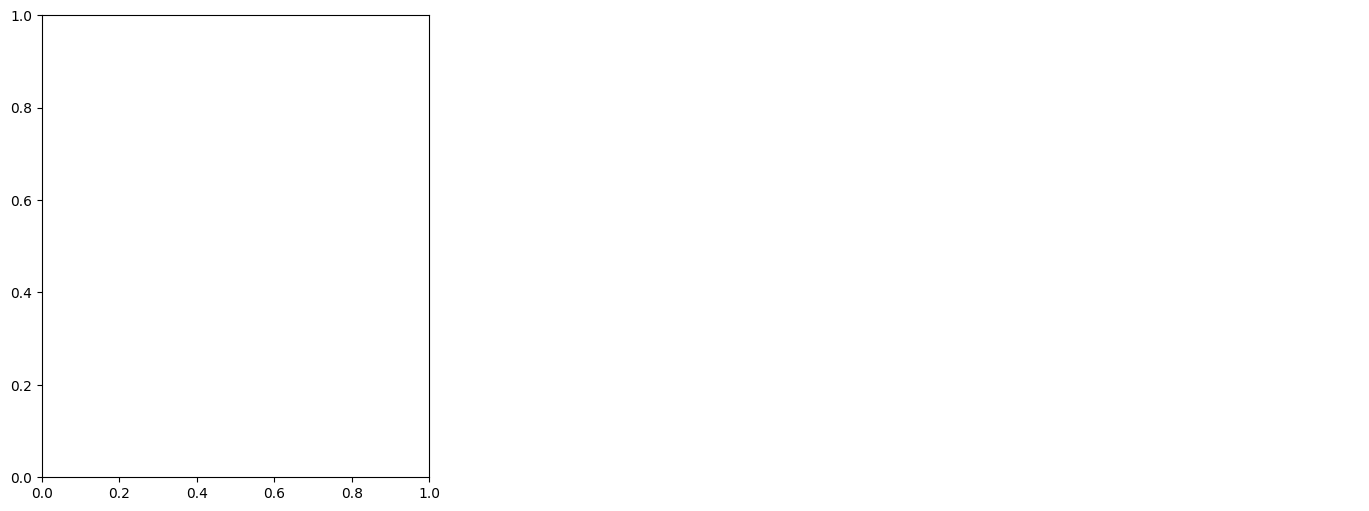

In [4]:
data_path="/data2/stan"
title="average ~12-13%"
workdir="semi_empirical_v2/CEU_enrichedEr/g-1000"
postfix="CEU_enrichedEr"
option="pval"

power_qb(workdir,calculation=option,postfix=postfix,theta_alt=0.5,alpha=0.05,gene=1000,hets=None,depth=None,Num_col=3,if_AA=False)

### ROC

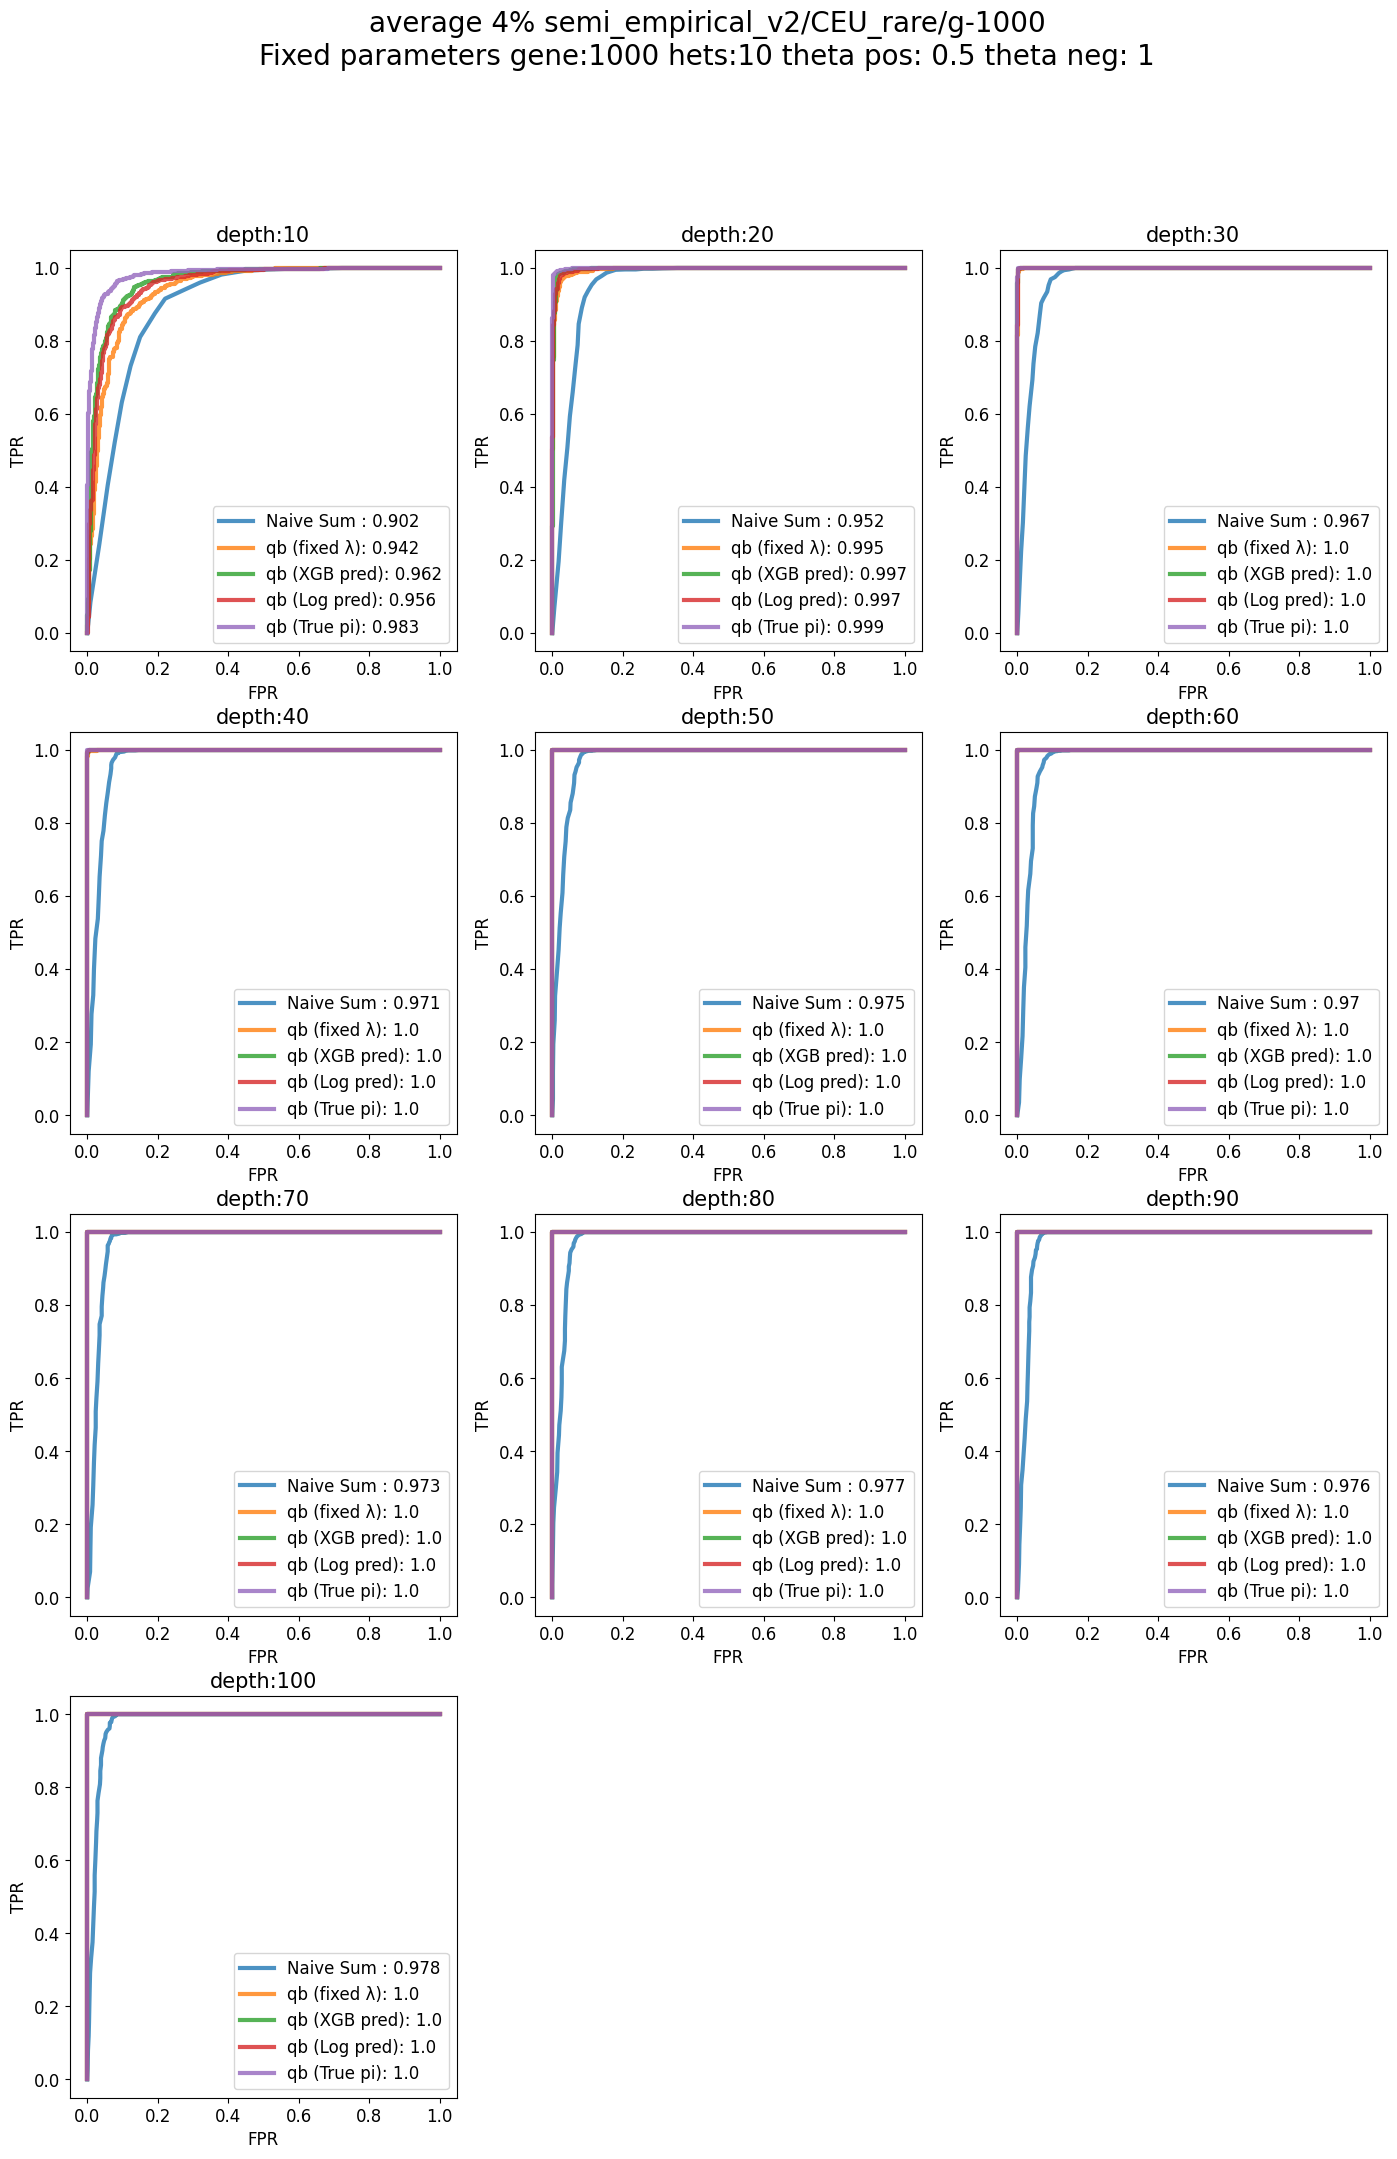

In [9]:
data_path="/data2/stan"
title="average 4%"
work_dir="semi_empirical_v2/CEU_rare/g-1000"
option="pval"
sigma=0.7
hets=10
depth=None
ROC_comparison_fix3_qb_MaxSite(data_path,work_dir,calculation=option,theta_pos=0.5,theta_neg=1,gene=1000,hets=hets,depth=depth,sigma=sigma,title=title,Num_col=3)

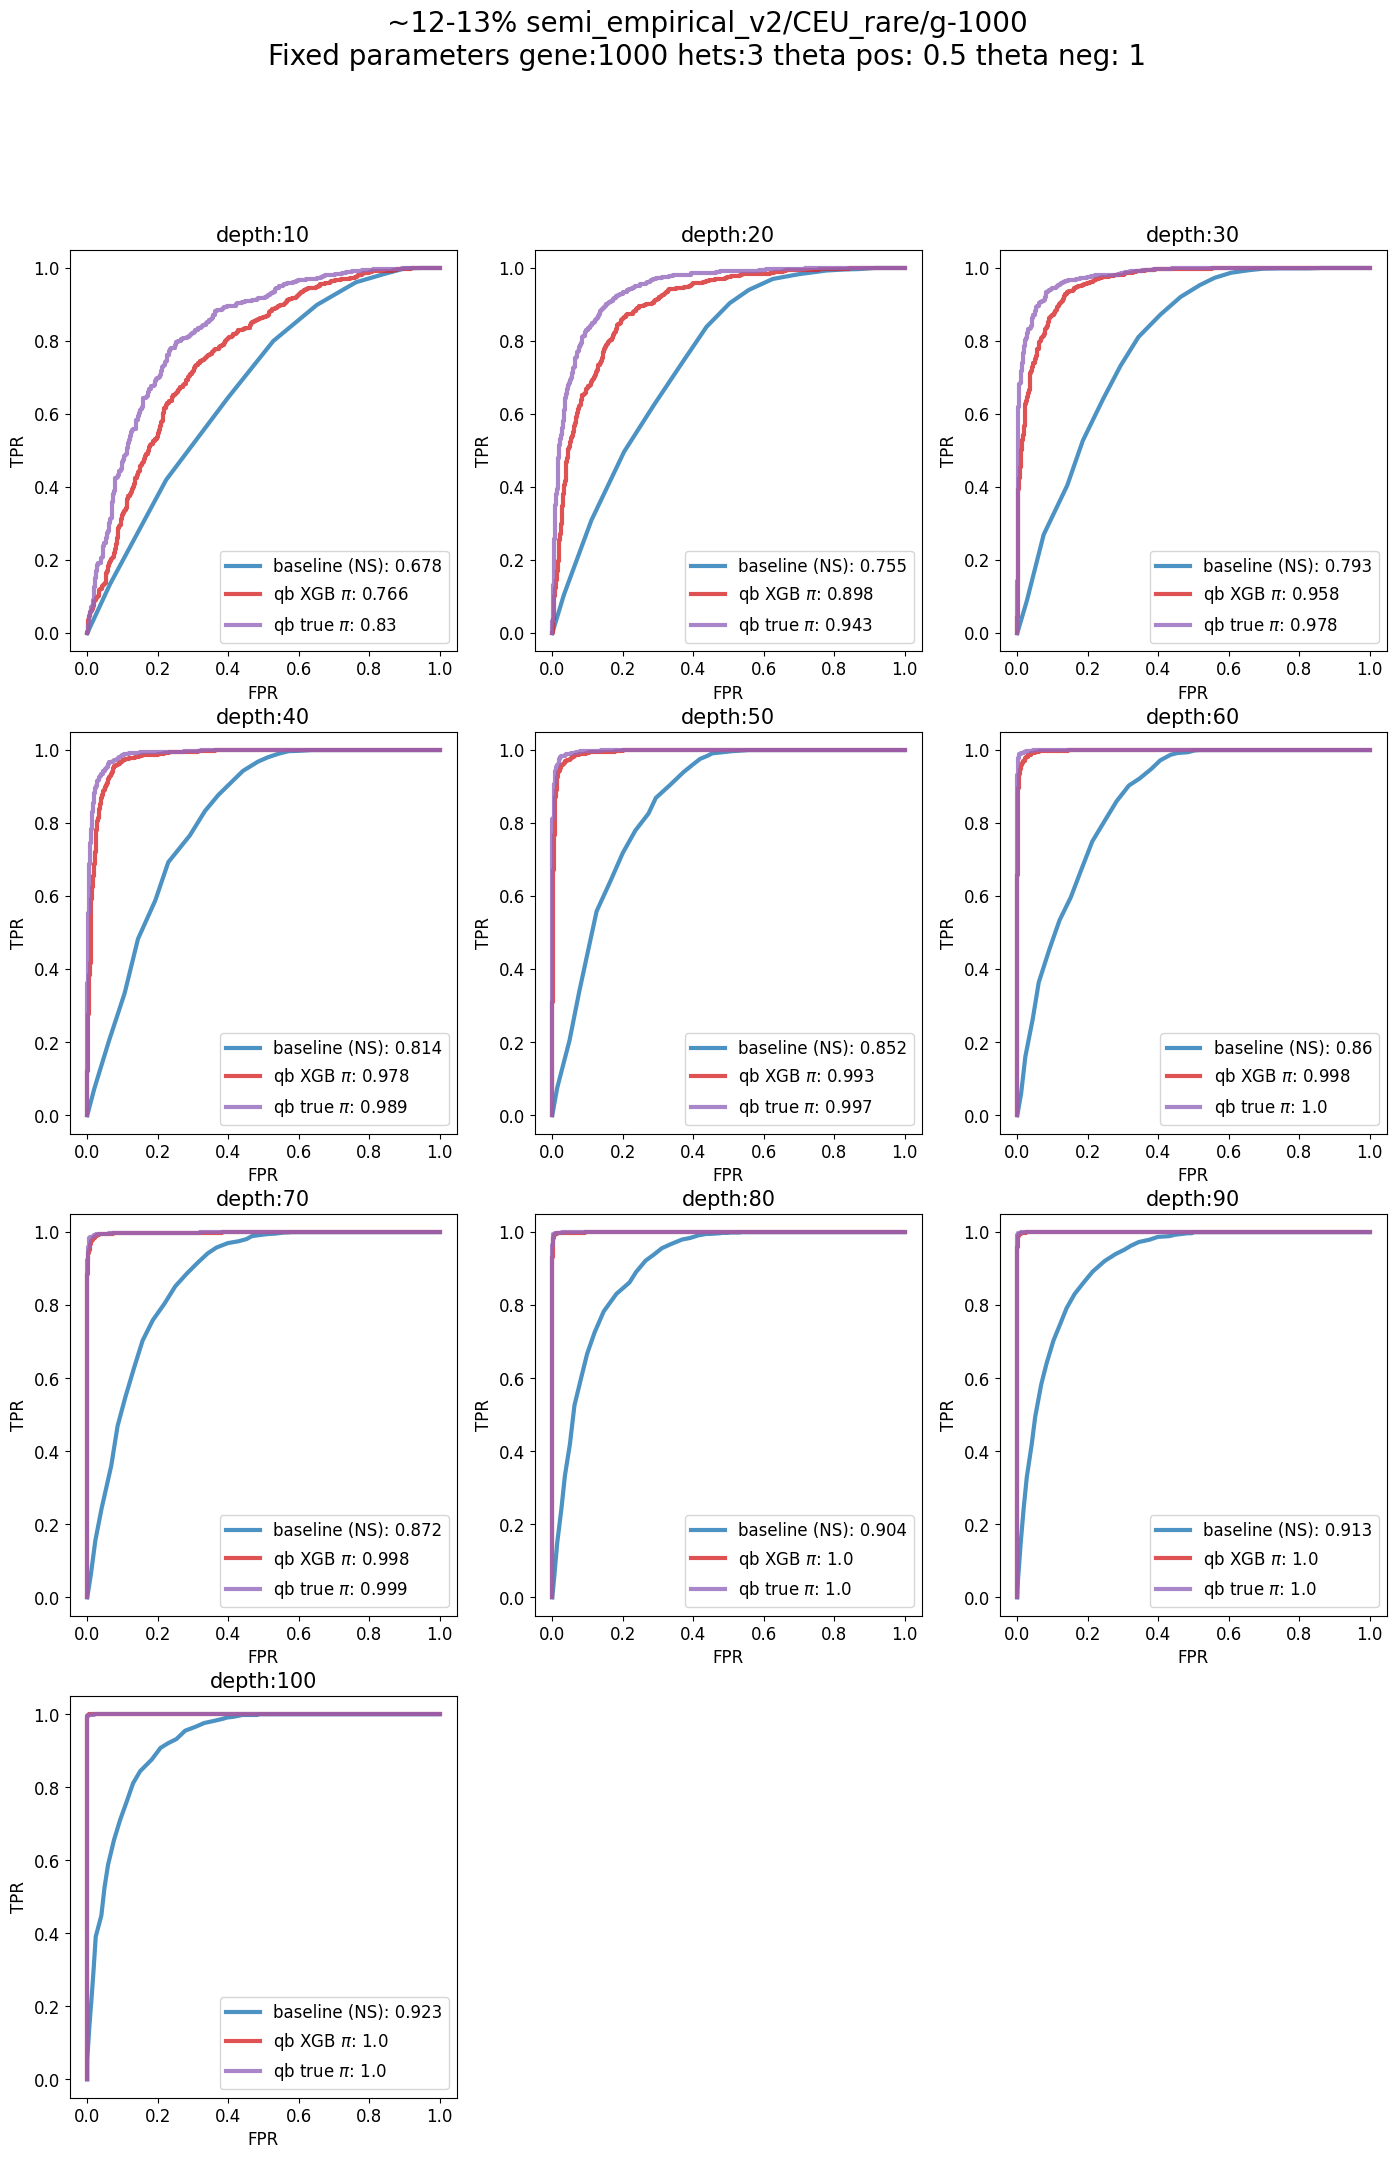

In [24]:
data_path="/data2/stan"
title="~12-13%"
work_dir="semi_empirical_v2/CEU_rare/g-1000"
option="pval"
hets=3
depth=None
ROC_comparison_fix3_qb_MaxSite(data_path,work_dir,calculation=option,theta_pos=0.5,theta_neg=1,gene=1000,hets=hets,depth=depth,sigma=sigma,title=title,Num_col=3)

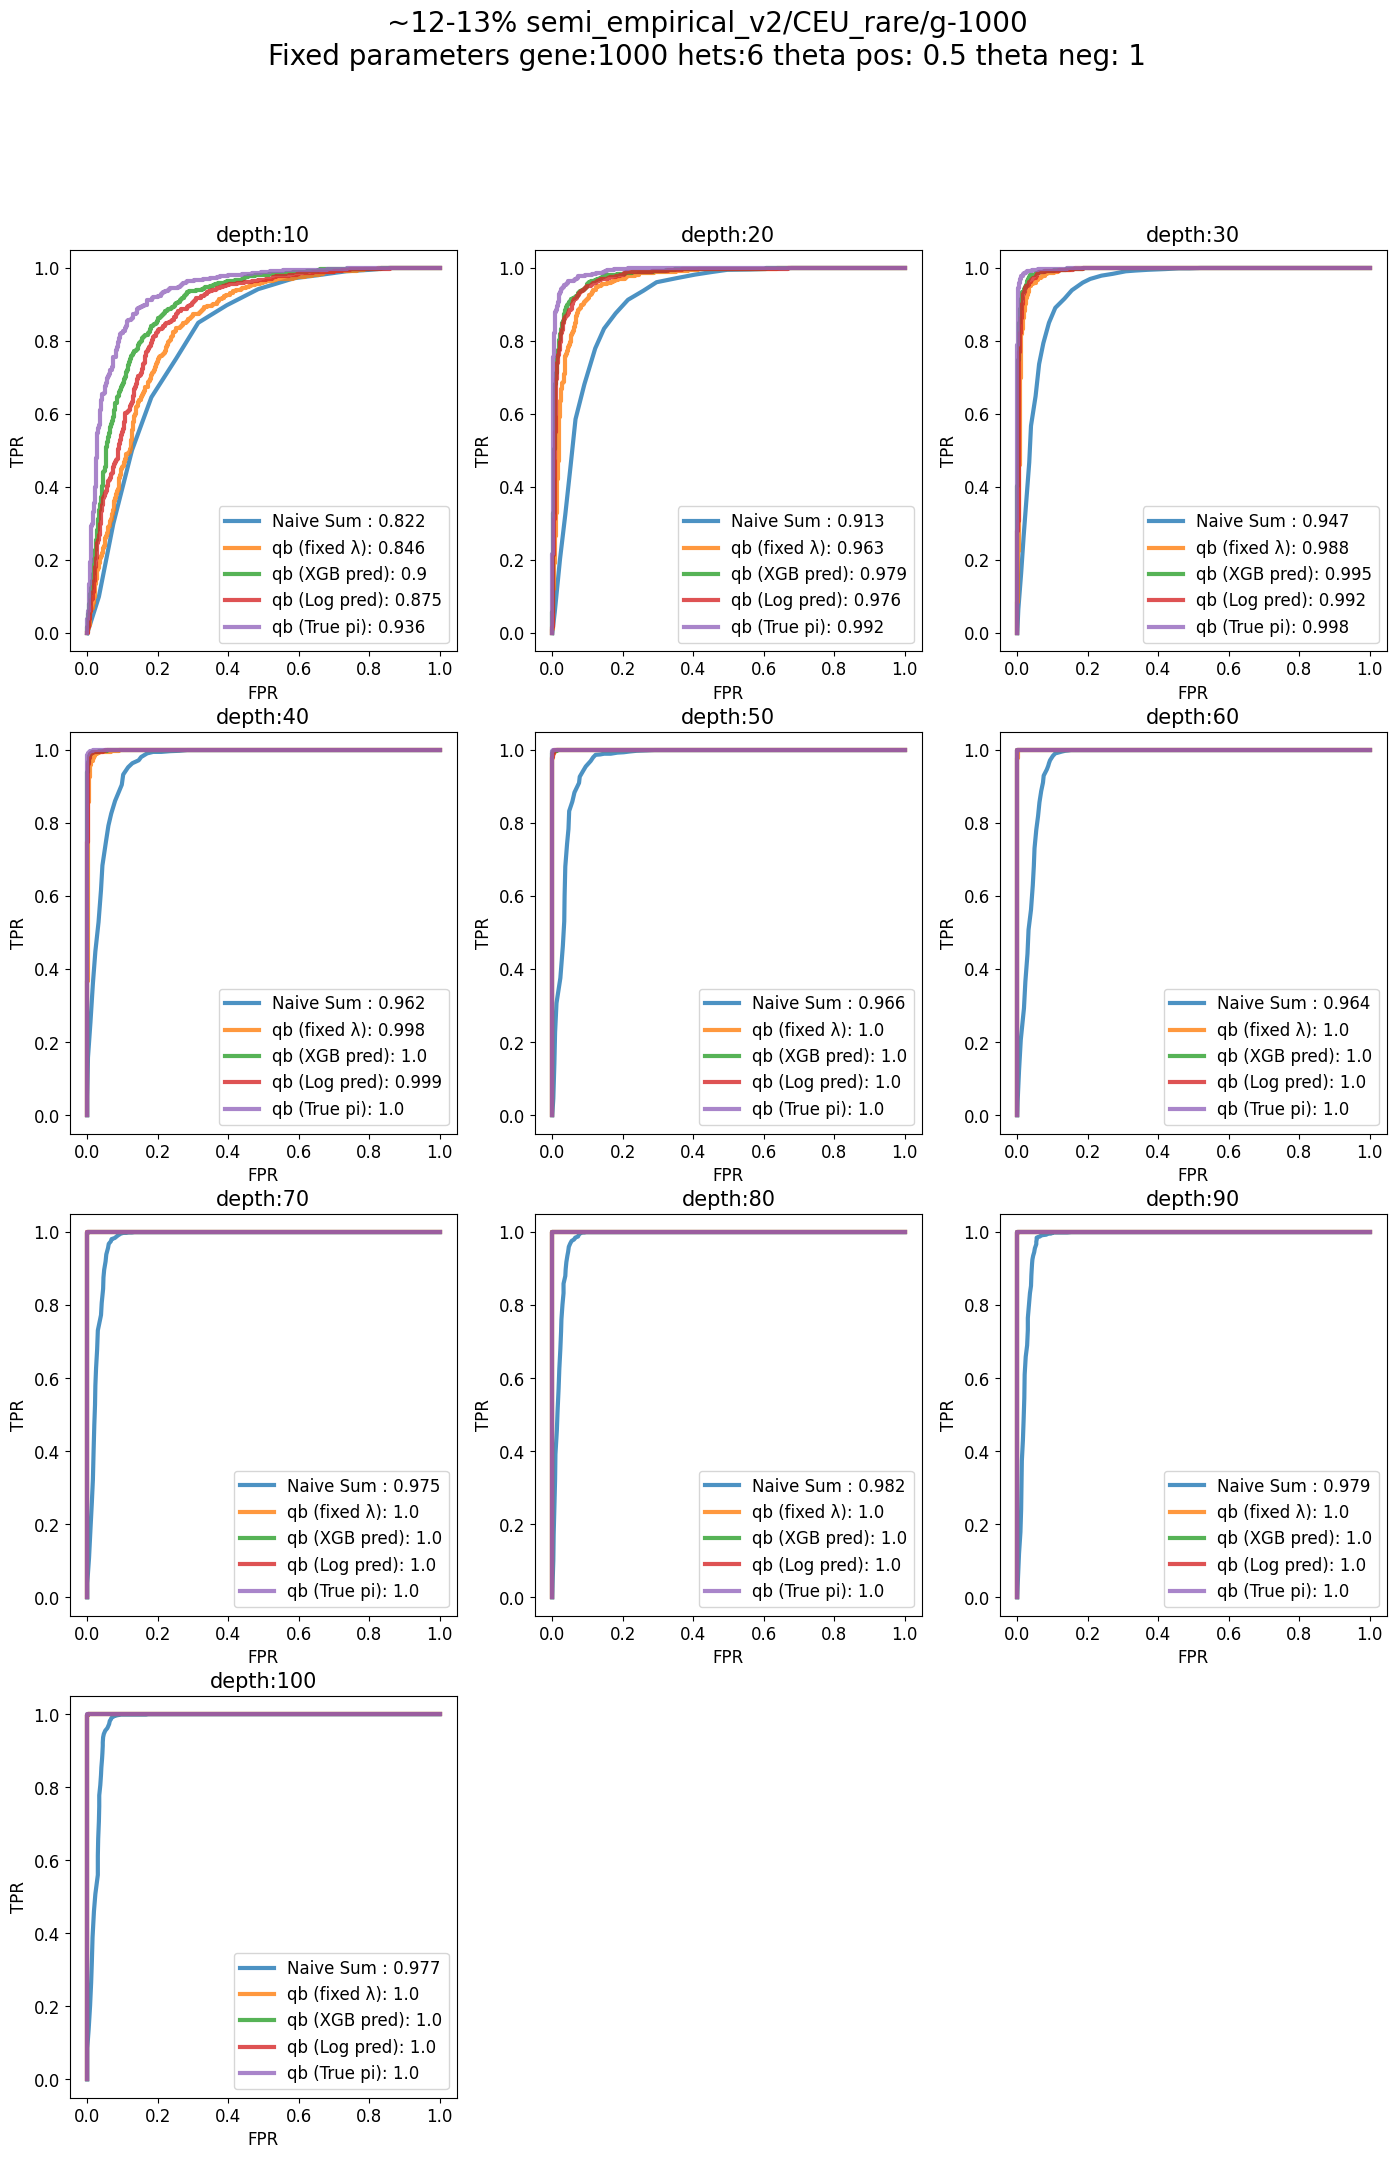

In [12]:
data_path="/data2/stan"
title="~12-13%"
work_dir="semi_empirical_v2/CEU_rare/g-1000"
option="pval"
hets=6
depth=None
ROC_comparison_fix3_qb_MaxSite(data_path,work_dir,calculation=option,theta_pos=0.5,theta_neg=1,gene=1000,hets=hets,depth=depth,sigma=sigma,title=title,Num_col=3)

In [ ]:
data_path="/data2/stan"
title="~12-13%"
work_dir="semi_empirical_v2/CEU/g-1000"
option="pval"
hets=3
depth=None
ROC_comparison_fix3_qb_MaxSite(data_path,work_dir,calculation=option,theta_pos=0.5,theta_neg=1,gene=1000,hets=hets,depth=depth,sigma=sigma,title=title,Num_col=3)

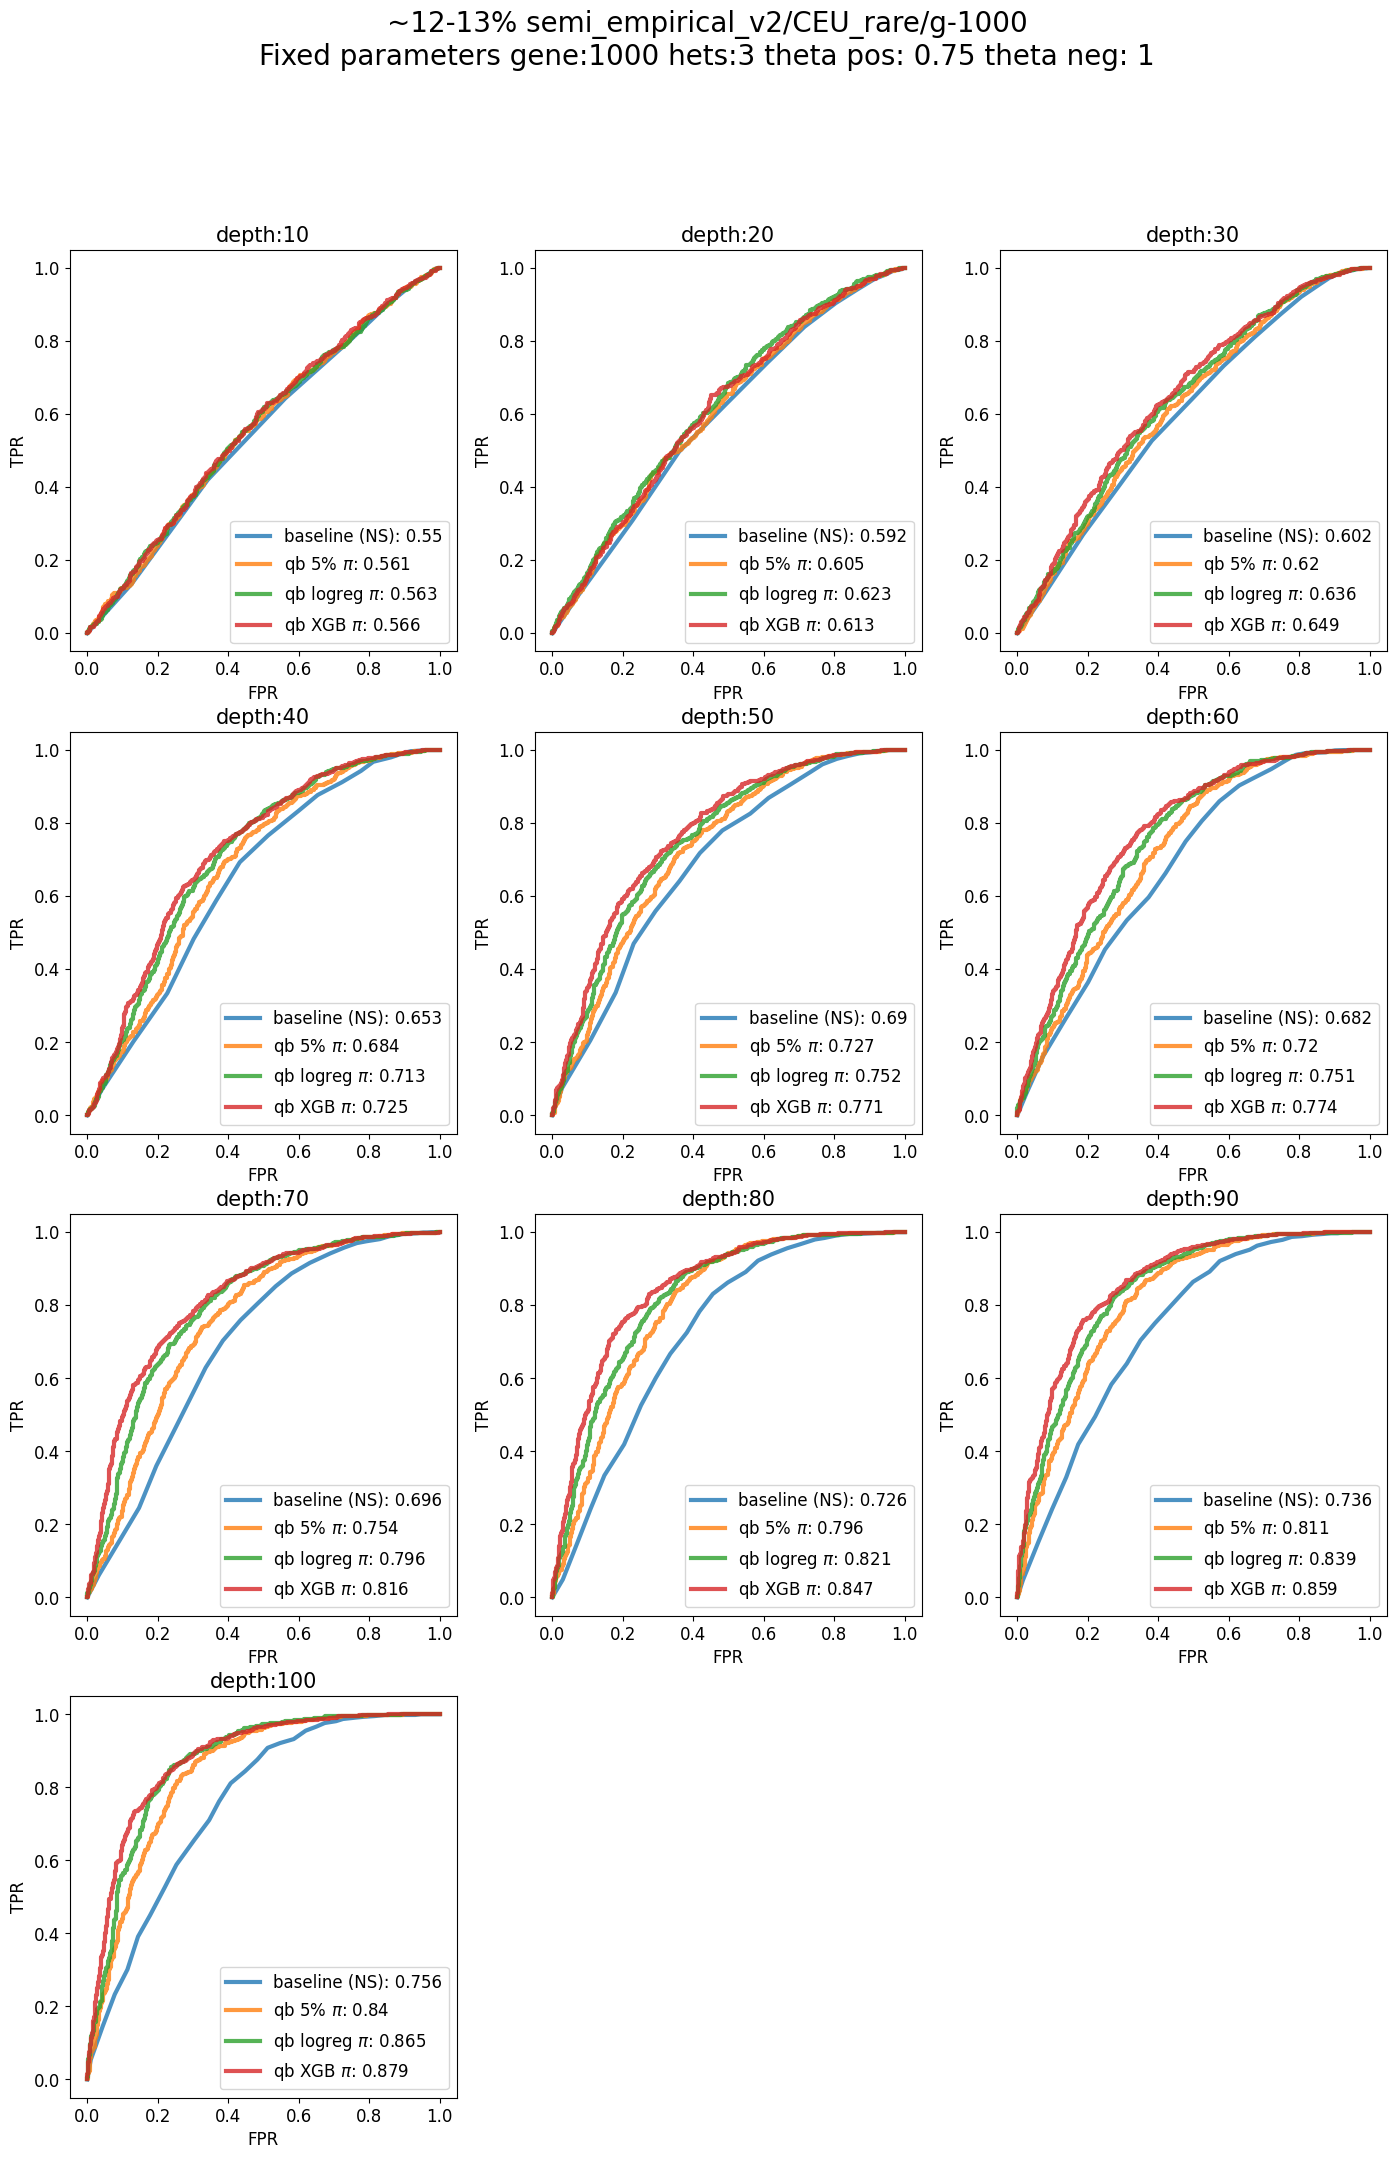

In [22]:
data_path="/data2/stan"
title="~12-13%"
work_dir="semi_empirical_v2/CEU_rare/g-1000"
option="pval"
hets=3
depth=None
ROC_comparison_fix3_qb_MaxSite(data_path,work_dir,calculation=option,theta_pos=0.75,theta_neg=1,gene=1000,hets=hets,depth=depth,sigma=sigma,title=title,Num_col=3)